<a href="https://colab.research.google.com/github/Sino-taku/PyTorch_Reference-/blob/main/Machine_learning_of_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#線形回帰

今回は「ボストン・データセット」と呼ばれるボストン近郊を506の地域に分割し、それぞれの地域で様々な観点の統計情報を取得している、今回はその中の「住宅平均価格」があり、他の項目から住宅平均価格を予想するという線形回帰を行います。

まずは入力項目のうち「平均部屋数」を意味するRMという項目を使って、目的変数に当たる不動産価格を予想する、単回帰と呼ばれるモデルを作ります。
予想関数には「線形単回帰」と呼ばれるモデルを作ります。

後半では、もう一つ「低所得者率」を意味するLSTATという項目を追加します、２入力１出力のモデルを作ります。このモデルは「重回帰」と呼ばれます。


In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)


#線形関数（nn.Linear)の解説

このレイヤー関数はインスタンス生成時、２つの引数をとります。最初の引数は入力テンソルの次元数を次の引数は出力テンソルの次元数を意味します。

In [2]:
# 乱数の種固定
torch.manual_seed(123)

# 入力:1 出力:1 の線形関数の定義
l1 = nn.Linear(1, 1)

# 線形関数の表示
print(l1)



Linear(in_features=1, out_features=1, bias=True)


print関数の出力結果で、確かに1入力1出力になっ
ています。biasは関数に定数項を含めるかどうかのオプションで、デフォルトではTrueになっています。

統計的にnamed_parametersという関数が組み込まれています。
この関数を呼び出すと（パラメータ名,パラメータ参照）のリストを返してくれます。


In [3]:
# パラメータ名、パラメータ値、shapeの表示

for param in l1.named_parameters():
    print('name: ', param[0])
    print('tensor: ', param[1])
    print('shape: ', param[1].shape)

name:  weight
tensor:  Parameter containing:
tensor([[-0.4078]], requires_grad=True)
shape:  torch.Size([1, 1])
name:  bias
tensor:  Parameter containing:
tensor([0.0331], requires_grad=True)
shape:  torch.Size([1])


上記の出力の結果からweightとbiasがランダムに設定されていることがわかります。

通常乱数値がセットされているパラメーターを明示的に設定したい場合、以下のコードのようにnn.init.constantを呼び出します。

y=2*x+1

In [4]:
# 初期値設定
nn.init.constant_(l1.weight, 2.0)
nn.init.constant_(l1.bias, 1.0)

# 結果確認
print(l1.weight)
print(l1.bias)

Parameter containing:
tensor([[2.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


最後に一次関数として機能していることを確認します。まずはテストデータを作成します。

In [5]:
# テスト用データ生成

# x_npをnumpy配列で定義
x_np = np.arange(-2, 2.1, 1)

# Tensor化
x = torch.tensor(x_np).float()

# サイズを(N,1)に変更
x = x.view(-1,1)

# 結果確認
print(x.shape)
print(x)

torch.Size([5, 1])
tensor([[-2.],
        [-1.],
        [ 0.],
        [ 1.],
        [ 2.]])


上記で気を付けるところは「NumPy変数で用意した配列をテンソル変数化する前に、float関数をかけて、データ、データ型を変換している点です。

もう一つは、入力変数ｘは一次元テンソルで表現できるのに、わざわざshapeが[5,1]の二次元テンソルに変換している点です。
これはこの後で掛け算を行う先であるweightがスカラーでなく[1,1]の行列になっているのでエラーを起こさないようにしている

実装します。

In [6]:
# 1次関数のテスト

y = l1(x)

print(y.shape)
print(y.data)

torch.Size([5, 1])
tensor([[-3.],
        [-1.],
        [ 1.],
        [ 3.],
        [ 5.]])


#2入力1出力

次に2入力1出力の線形関数を作ってみましょう。

今回のようにweightが2個の場合すべての重みは初期値が1.0になります。

In [7]:
# 入力:2 出力:1 の線形関数の定義
l2 = nn.Linear(2, 1)

# 初期値設定
nn.init.constant_(l2.weight, 1.0)
nn.init.constant_(l2.bias, 2.0)

# 結果確認
print(l2.weight)
print(l2.bias)

Parameter containing:
tensor([[1., 1.]], requires_grad=True)
Parameter containing:
tensor([2.], requires_grad=True)


今度は入力テンソルが二つの2次元テンソルになります。次のコードの4行2列のテストデータを準備しました。

In [8]:
# 2次元numpy配列
x2_np = np.array([[0, 0], [0, 1], [1, 0], [1,1]])

# Tensor化
x2 =  torch.tensor(x2_np).float()

# 結果確認
print(x2.shape)
print(x2)

torch.Size([4, 2])
tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])


このデータを使った関数呼び出しテストの実装と結果は次になります。

In [9]:
# 関数値計算
y2 = l2(x2)

# shape確認
print(y2.shape)

# 値確認
print(y2.data)

torch.Size([4, 1])
tensor([[2.],
        [3.],
        [3.],
        [4.]])


上記は関数の式はy=X+Xp+2なので、(X,Xp)に(0,1)や(1,1)を代入した結果通りの答えが得られます。

#2入力3出力

同じ流れで出力を3つに増やしてみましょう。

In [10]:
#入力:2 出力:3 の線形関数の定義

l3 = nn.Linear(2, 3)

# 初期値設定
nn.init.constant_(l3.weight[0,:], 1.0)
nn.init.constant_(l3.weight[1,:], 2.0)
nn.init.constant_(l3.weight[2,:], 3.0)
nn.init.constant_(l3.bias, 2.0)

# 結果確認
print(l3.weight)
print(l3.bias)

Parameter containing:
tensor([[1., 1.],
        [2., 2.],
        [3., 3.]], requires_grad=True)
Parameter containing:
tensor([2., 2., 2.], requires_grad=True)


今度は、重み行列の初期値を行ごとに別の値にしたため、コードがやや複雑になっています。
入力は先ほど用意したx2がそのまま使えるので、このテンソルを使ってテストした結果が、次になります。

In [11]:
# 関数値計算
y3 = l3(x2)

# shape確認
print(y3.shape)

# 値確認
print(y3.data)

torch.Size([4, 3])
tensor([[2., 2., 2.],
        [3., 4., 5.],
        [3., 4., 5.],
        [4., 6., 8.]])


今回は

入力テンソルｘ：[4,2]

重み行列l3.weight：[3,2]

バイアスl3.bias：[3]

の間での計算となります。入力テンソルと重み行列の演算は行列同士の掛け算になります。

p164

#カスタムクラスを利用したモデルの定義

大きく予測関数、損失関数、最適化関数の3つのパートに分かれています。「カスタムクラスによるモデルの定義」とは、この中の予測関数に関わるパートです。



In [12]:
# モデルのクラス定義

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        #  親クラスnn.Modulesの初期化呼び出し
        super().__init__()

        # 出力層の定義
        self.l1 = nn.Linear(n_input, n_output)   
        
    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x) # 線形回帰
        return x1

カスタムクラスを利用してモデルを定義した場合、予想は次のコードのように実装します。

In [13]:
# ダミー入力
inputs = torch.ones(100,1)

# インスタンスの生成 (１入力1出力の線形モデル)
n_input = 1
n_output = 1
net = Net(n_input, n_output)

# 予測
outputs = net(inputs)

次にMSELossクラスを利用した損失関数

これは機械学習全体で見た損失計算と勾配計算の役割を改めてまとめます。

・「損失loss」とは、「予測関数」と「損失関数」を組み合わせて出来上がった合成関数を計算することを意味します。

・この合成関数（損失）はパラメータ（weightとbias)を引数とします。

・合成関数（損失）をパラメータで偏微分することが「勾配計算」であり、勾配計算の結果が勾配降下法の「パラメータ修正」で用いられます。

このような関係性を頭に置いた上で欠損関数に関する以下の解説を読み進めてください。

#データ準備



In [14]:

import pandas as pd
# 「ボストン・データセット」はscikit-learnのライブラリでも取得できるが、
# その場合、将来版で利用できなくなる予定のため、別Webサイトから取得する
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
x_org = np.hstack([raw_df.values[::2, :], 
    raw_df.values[1::2, :2]])
yt = raw_df.values[1::2, 2]
feature_names = np.array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
    'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO','B', 'LSTAT'])

# 結果確認
print('元データ', x_org.shape, yt.shape)
print('項目名: ', feature_names)

元データ (506, 13) (506,)
項目名:  ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


次に、入力データに関して平均部屋数（RM）の一項目だけを抜き出します。

In [15]:
# データ絞り込み (項目 RMのみ)
x = x_org[:,feature_names == 'RM']
print('絞り込み後', x.shape)
print(x[:5,:])

# 正解データ yの表示
print('正解データ')
print(yt[:5])

絞り込み後 (506, 1)
[[6.575]
 [6.421]
 [7.185]
 [6.998]
 [7.147]]
正解データ
[24.  21.6 34.7 33.4 36.2]


最後に絞り込みで取得したｘと正解値ytの関係を散布図で確認します。

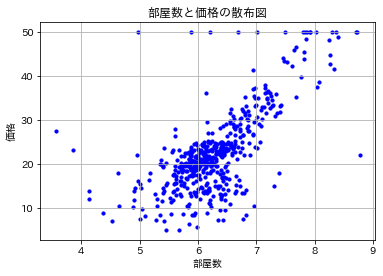

In [16]:
import matplotlib.pyplot as plt

# 散布図の表示

plt.scatter(x, yt, s=10, c='b')
plt.xlabel('部屋数')
plt.ylabel('価格')
plt.title('部屋数と価格の散布図')
plt.show()

#モデル定義

変数定義をします、まず、n_inputとn_outputについて説明します。機械学習・ディープラーニングモデルとは、結局「入力ベクトルに対して出力ベクトルを返す関数である」ということが可能です。



In [17]:
# 変数定義

# 入力次元数
n_input= x.shape[1]

# 出力次元数
n_output = 1

print(f'入力次元数: {n_input}  出力次元数: {n_output}')

入力次元数: 1  出力次元数: 1


機械学習モデル（予測モデル）のクラス定義

次のコードが、機械学習モデルのクラス構造を定義している最も重要な実装です。

In [18]:
# 機械学習モデル（予測モデル）クラス定義

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        #  親クラスnn.Modulesの初期化呼び出し
        super().__init__()

        # 出力層の定義
        self.l1 = nn.Linear(n_input, n_output)   
        
        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的
        nn.init.constant_(self.l1.weight, 1.0)
        nn.init.constant_(self.l1.bias, 1.0)

    # 予測関数の定義
    def forward(self, x):
        x1 = self.l1(x) # 線形回帰
        return x1

・カスタムクラスNetが、nn.Moduleの子クラスとして定義されている

・冒頭の__init__関数で初期化処理をしている

・__init__関数の内部で親クラスの__init__関数を呼んでいる

というのが読み取れます、よくわからない場合はクラスとインスタンスについて勉強してください。

インスタンス生成

次のコードは今定義したクラスNetからインスタンス変数を生成します。

In [19]:
# インスタンスの生成
# １入力1出力の線形モデル

net = Net(n_input, n_output)

インスタンス生成時の引数として入力次元数（＝1）と出力次元数（＝1）を渡しています。

Netクラスのインスタンスであるnet変数を定義すると、次の呼び出し方で、入力テンソルから、予測値である出力テンソルを取得可能です。

In [20]:
outputs=net(inputs)

Q　モデル内の変数値表示

こうやって生成したモデルを表す変数Netでは、親クラスのnn.Module内で定義されている機能を利用できます。

named_parameters関数：モデル内の変数名とその値を取得する

parameters関数：パラメータ変数だけが名前なしにリスト形式で返してきます。

In [21]:
# モデル内のパラメータの確認
# モデル内の変数取得にはnamed_parameters関数を利用する
# 結果の第1要素が名前、第2要素が値
# 
# predict.weightとpredict.biasがあることがわかる
# 初期値はどちらも1.0になっている

for parameter in net.named_parameters():
    print(f'変数名: {parameter[0]}')
    print(f'変数値: {parameter[1].data}')

変数名: l1.weight
変数値: tensor([[1.]])
変数名: l1.bias
変数値: tensor([1.])


In [22]:
# パラメータのリスト取得にはparameters関数を利用する

for parameter in net.parameters():
    print(parameter)

Parameter containing:
tensor([[1.]], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


Q　モデルの概要表示

機械学習はニューラルネットワークの構造が最も重要です。今回は二つ紹介します。

まず一つ目はモデルのインスタンスをそのままprint関数に渡す方法する



In [23]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=1, out_features=1, bias=True)
)


もう一つはtorchinfoという専用のライブラリを利用する方法です。

In [24]:
# モデルのサマリー表示

from torchinfo import summary
summary(net, (1,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Linear: 1-1                            [1]                       2
Total params: 2
Trainable params: 2
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

summaryという関数を呼び出すのですが、引数としてnet関数そのものと、入力変数のサイズを指定します。今回の入力は1変数なので、(1,)を指定します。

Q　損失関数と最適化関数の定義

機械学習のアルゴリズムの中で重要なうちの二つを行います。

In [25]:
# 損失関数： 平均2乗誤差
criterion = nn.MSELoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

#勾配降下法

まとめたコードの前に重要な部分を学びましょう。

Q　入力値ｘと正解値ytのテンソル化

冒頭で散布図描画に使ったX,Y をテンソル化します。

In [26]:
# 入力変数x と正解値 ytのテンソル変数化

inputs = torch.tensor(x).float()
labels = torch.tensor(yt).float()

# 次元数確認

print(inputs.shape)
print(labels.shape)

torch.Size([506, 1])
torch.Size([506])


正解値をテンソル変数化した変数labelsに関しては、これからMSELossのインスタンスであるcriterion関数に、予測値とともに渡して、損失を計算します。その時に引数はN次元ベクトル形式でなく、(N,1)次元の行列形式であることが必要です。
そのためにview関数を利用してデータサイズを変更するための実装が次になります。

In [27]:
# 損失値計算用にlabels変数を(N,1)次元の行列に変換する

labels1 = labels.view((-1, 1))

# 次元数確認
print(labels1.shape)

torch.Size([506, 1])


これで用意は整ました、あとは

①　予測関数

②　損失関数

③　勾配計算

④　パラメータ修正

を繰り返せば完成です。

①予測関数



308.44986


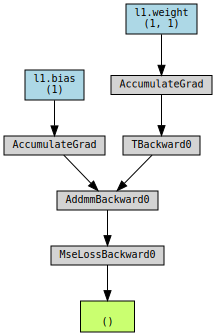

tensor([[-199.6421]])
tensor([-30.4963])
Parameter containing:
tensor([[2.9964]], requires_grad=True)
Parameter containing:
tensor([1.3050], requires_grad=True)
tensor([[0.]])
tensor([0.])


In [28]:
# 予測計算

outputs = net(inputs)


#  損失計算
loss = criterion(outputs, labels1)

# 損失値の取得
print(f'{loss.item():.5f}')

# 損失の計算グラフ可視化

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels1)

# 勾配計算
loss.backward()

# 勾配の結果が取得可能に
print(net.l1.weight.grad)
print(net.l1.bias.grad)

# パラメータ修正
optimizer.step()

# パラメータ値が変わる
print(net.l1.weight)
print(net.l1.bias)


# 勾配値の初期化
optimizer.zero_grad()

# 勾配値がすべてゼロになっている
print(net.l1.weight.grad)
print(net.l1.bias.grad)

Q　繰り返し計算

上記の処理を繰り返せば、最適なパラメータが見つかるはずです。

In [29]:
# 学習率
lr = 0.01

# インスタンス生成　(パラメータ値初期化)
net = Net(n_input, n_output)

# 損失関数： 平均2乗誤差
criterion = nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50000

# 評価結果記録用 (損失関数値のみ記録)
history = np.zeros((0,2))

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    
    # 勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
  
    # 損失計算
    # 「ディープラーニングの数学」に合わせて2で割った値を損失とした
    loss = criterion(outputs, labels1) / 2.0

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回ごとに途中経過を記録する
    if ( epoch % 100 == 0):
        history = np.vstack((history, np.array([epoch, loss.item()])))
        print(f'Epoch {epoch} loss: {loss.item():.5f}')

Epoch 0 loss: 154.22493
Epoch 100 loss: 29.61752
Epoch 200 loss: 29.43177
Epoch 300 loss: 29.25043
Epoch 400 loss: 29.07340
Epoch 500 loss: 28.90057
Epoch 600 loss: 28.73186
Epoch 700 loss: 28.56715
Epoch 800 loss: 28.40636
Epoch 900 loss: 28.24939
Epoch 1000 loss: 28.09615
Epoch 1100 loss: 27.94655
Epoch 1200 loss: 27.80050
Epoch 1300 loss: 27.65792
Epoch 1400 loss: 27.51873
Epoch 1500 loss: 27.38285
Epoch 1600 loss: 27.25020
Epoch 1700 loss: 27.12070
Epoch 1800 loss: 26.99428
Epoch 1900 loss: 26.87086
Epoch 2000 loss: 26.75037
Epoch 2100 loss: 26.63275
Epoch 2200 loss: 26.51792
Epoch 2300 loss: 26.40582
Epoch 2400 loss: 26.29639
Epoch 2500 loss: 26.18955
Epoch 2600 loss: 26.08525
Epoch 2700 loss: 25.98343
Epoch 2800 loss: 25.88404
Epoch 2900 loss: 25.78700
Epoch 3000 loss: 25.69226
Epoch 3100 loss: 25.59978
Epoch 3200 loss: 25.50950
Epoch 3300 loss: 25.42136
Epoch 3400 loss: 25.33532
Epoch 3500 loss: 25.25132
Epoch 3600 loss: 25.16932
Epoch 3700 loss: 25.08927
Epoch 3800 loss: 25.011

#結果確認

損失初期値: 154.22493
損失最終値: 21.80033


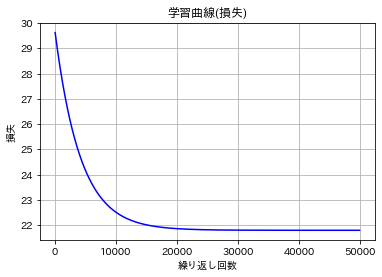

[[-2.2189]
 [45.2121]]


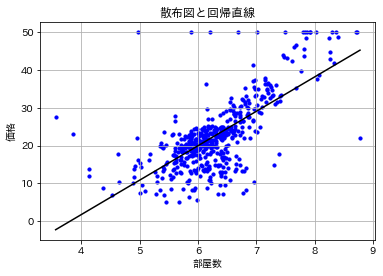

In [30]:
# 損失初期値と最終値

print(f'損失初期値: {history[0,1]:.5f}')
print(f'損失最終値: {history[-1,1]:.5f}')

# 学習曲線の表示 (損失) 
# 最初の1つを除く

plt.plot(history[1:,0], history[1:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.show()

# 回帰直線の算出

# xの最小値、最大値
xse = np.array((x.min(), x.max())).reshape(-1,1)
Xse = torch.tensor(xse).float()

with torch.no_grad():
  Yse = net(Xse)

print(Yse.numpy())

# 散布図と回帰直線の描画

plt.scatter(x, yt, s=10, c='b')
plt.xlabel('部屋数')
plt.ylabel('価格')
plt.plot(Xse.data, Yse.data, c='k')
plt.title('散布図と回帰直線')
plt.show()

##重回帰モデルへの拡張

前回に新しい項目LSTATを追加し、2入力とします。

まずは列の追加

In [31]:
# 列(LSTAT: 低所得者率)の追加

x_add = x_org[:,feature_names == 'LSTAT']
x2 = np.hstack((x, x_add))

# shapeの表示
print(x2.shape)

# 入力データxの表示
print(x2[:5,:])

(506, 2)
[[6.575 4.98 ]
 [6.421 9.14 ]
 [7.185 4.03 ]
 [6.998 2.94 ]
 [7.147 5.33 ]]


今度は入力データの次元数n_inputは２になります。
この値で、モデルインスタンスを生成し直します。

In [32]:
# 今度は入力次元数=2

n_input = x2.shape[1]
print(n_input)

# モデルインスタンスの生成
net = Net(n_input, n_output)

2


インスタンス変数がどう変わったか、いくつかの方法で確かめます。

In [33]:
# モデル内のパラメータの確認
# predict.weight が2次元に変わった

for parameter in net.named_parameters():
    print(f'変数名: {parameter[0]}')
    print(f'変数値: {parameter[1].data}')

変数名: l1.weight
変数値: tensor([[1., 1.]])
変数名: l1.bias
変数値: tensor([1.])


weightが二個に増えています

In [35]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
)


in_featuresが二個に増えています。

In [36]:
# モデルのサマリー表示

from torchinfo import summary
summary(net, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Linear: 1-1                            [1]                       3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

paramsが三個に増えています。（wightが二個、biasが一個）

次は新しい入力変数ｘ2を改めてinputsに定義します。

In [37]:
# 入力変数x2 のテンソル変数化 
# labels, labels1は前のものをそのまま利用

inputs = torch.tensor(x2).float()

これで準備完了です、繰り返しの処理を単回帰と同じく行います。

In [41]:
# 初期化処理

# 学習率
lr = 0.01

# インスタンス生成　(パラメータ値初期化)
net = Net(n_input, n_output)

# 損失関数： 平均2乗誤差
criterion = nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50000

# 評価結果記録用 (損失関数値のみ記録)
history = np.zeros((0,2))

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    
    # 勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
  
    # 誤差計算
    # 「ディープラーニングの数学」に合わせて2で割った値を損失とした
    loss = criterion(outputs, labels1) / 2.0

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回ごとに途中経過を記録する
    if ( epoch % 100 == 0):
        history = np.vstack((history, np.array([epoch, loss.item()])))
        print(f'Epoch {epoch} loss: {loss.item():.5f}')

Epoch 0 loss: 112.06398
Epoch 100 loss: 3753837073642659568666615480320.00000
Epoch 200 loss: inf
Epoch 300 loss: nan
Epoch 400 loss: nan
Epoch 500 loss: nan
Epoch 600 loss: nan
Epoch 700 loss: nan
Epoch 800 loss: nan
Epoch 900 loss: nan
Epoch 1000 loss: nan
Epoch 1100 loss: nan
Epoch 1200 loss: nan
Epoch 1300 loss: nan
Epoch 1400 loss: nan
Epoch 1500 loss: nan
Epoch 1600 loss: nan
Epoch 1700 loss: nan
Epoch 1800 loss: nan
Epoch 1900 loss: nan
Epoch 2000 loss: nan
Epoch 2100 loss: nan
Epoch 2200 loss: nan
Epoch 2300 loss: nan
Epoch 2400 loss: nan
Epoch 2500 loss: nan
Epoch 2600 loss: nan
Epoch 2700 loss: nan
Epoch 2800 loss: nan
Epoch 2900 loss: nan
Epoch 3000 loss: nan
Epoch 3100 loss: nan
Epoch 3200 loss: nan
Epoch 3300 loss: nan
Epoch 3400 loss: nan
Epoch 3500 loss: nan
Epoch 3600 loss: nan
Epoch 3700 loss: nan
Epoch 3800 loss: nan
Epoch 3900 loss: nan
Epoch 4000 loss: nan
Epoch 4100 loss: nan
Epoch 4200 loss: nan
Epoch 4300 loss: nan
Epoch 4400 loss: nan
Epoch 4500 loss: nan
Epoch 

欠損関数の値がinf→nanになってしまいます。これは欠損関数の値が発散して繰り返しの計算がうまくできなかったことを意味します。

結論から行くと今回の学習率が大きすぎたことが原因でした。

#学習率の変更

学習率lrを小さくして、繰り返しの回数を減らしました

Epoch 0 loss: 112.06398
Epoch 100 loss: 25.35892
Epoch 200 loss: 16.39105
Epoch 300 loss: 15.40301
Epoch 400 loss: 15.29414
Epoch 500 loss: 15.28211
Epoch 600 loss: 15.28076
Epoch 700 loss: 15.28059
Epoch 800 loss: 15.28054
Epoch 900 loss: 15.28051
Epoch 1000 loss: 15.28048
Epoch 1100 loss: 15.28046
Epoch 1200 loss: 15.28043
Epoch 1300 loss: 15.28040
Epoch 1400 loss: 15.28037
Epoch 1500 loss: 15.28034
Epoch 1600 loss: 15.28031
Epoch 1700 loss: 15.28028
Epoch 1800 loss: 15.28026
Epoch 1900 loss: 15.28023
損失初期値: 112.06398
損失最終値: 15.28023


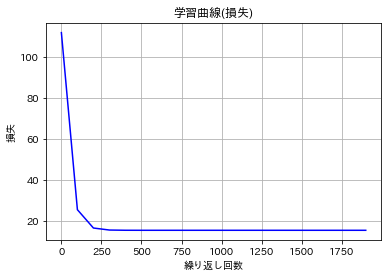

In [42]:
# 繰り返し回数
#num_epochs = 50000
num_epochs = 2000

# 学習率
#l r = 0.01
lr = 0.001

# モデルインスタンスの生成
net = Net(n_input, n_output)

# 損失関数： 平均2乗誤差
criterion = nn.MSELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し計算メインループ

# 評価結果記録用 (損失関数値のみ記録)
history = np.zeros((0,2))

for epoch in range(num_epochs):
    
    # 勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)
  
    # 誤差計算
    loss = criterion(outputs, labels1) / 2.0

    #勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 100回ごとに途中経過を記録する
    if ( epoch % 100 == 0):
        history = np.vstack((history, np.array([epoch, loss.item()])))
        print(f'Epoch {epoch} loss: {loss.item():.5f}')

# 損失初期値、最終値

print(f'損失初期値: {history[0,1]:.5f}')
print(f'損失最終値: {history[-1,1]:.5f}')

# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.show()


前回に比べて欠損が減っているので今回のほうが良いことがわかりました。